In [446]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import seaborn as sns

In [447]:
u = np.random.uniform(low=-40,high=10,size=8000)
n = np.random.normal(loc=-20,scale=3,size=4000)
u1 = np.hstack([u,n])

u2 = np.random.uniform(low=8,high=30,size=8000)
n1 = np.random.normal(loc=25,scale=2,size=4000)
u3 = np.hstack([u2,n1])

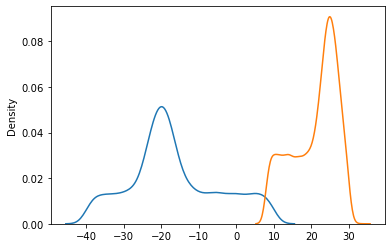

In [503]:
sns.kdeplot(u1)
sns.kdeplot(u3)
plt.show()

# Training with raw data

In [449]:
samp = np.random.choice(u1,250)
samp1 = np.random.choice(u3,250) 

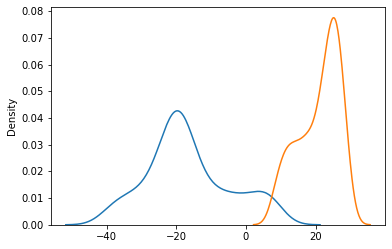

In [502]:
sns.kdeplot(samp)
sns.kdeplot(samp1)
plt.show()

In [451]:
train = np.hstack([samp,samp1])
y_train1 = np.array([-1]*len(samp))
y_train2 = np.ones(len(samp1))
y_train = np.hstack([y_train1,y_train2])

In [452]:
X_train, X_test, Y_train, Y_test = train_test_split(train, y_train, test_size = 0.3, random_state = 42)

In [453]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train.reshape(-1,1), Y_train)

In [454]:
prediction = clf.predict(X_test.reshape(-1,1))

In [455]:
np.sum(prediction==Y_test)/len(prediction)*100

98.66666666666667

# Training with Smoothed data

In [346]:
x_a = np.linspace(-45,20,500)
x_b = np.linspace(0,40,500)

In [347]:
def gaussian_smoothed_density(sample,x,sigma=5):
    a = np.zeros(len(x))
    for i in range(len(x)):
        for j in sample:
            a[i]+= (1/(sigma*len(sample)*np.sqrt(np.pi*2)))*np.exp(-((x[i]-j)**2)/(2*sigma**2))
    return a

In [348]:
aa = gaussian_smoothed_density(samp,x=x_a)
bb = gaussian_smoothed_density(samp1,x=x_b)

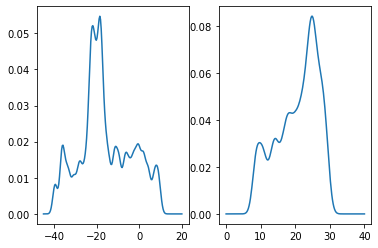

In [349]:
figure, axis = plt.subplots(1, 2)
axis[0].plot(x_a,aa)
axis[1].plot(x_b,bb)
plt.show()

In [350]:
x_train1 = np.random.choice(x_a,replace=True,p=aa/sum(aa),size=250)
x_train2 = np.random.choice(x_b,replace=True,p=bb/sum(bb),size=250)

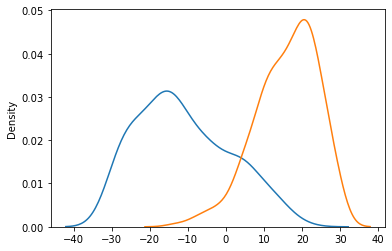

In [501]:
sns.kdeplot(x_train1)
sns.kdeplot(x_train2)
plt.show()

In [352]:
x_train = np.hstack([x_train1,x_train2])

In [353]:
y_train1 = np.zeros(len(x_train1))-1
y_train2 = np.ones(len(x_train2))
y_train = np.hstack([y_train1,y_train2])

In [354]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 42)

In [355]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train.reshape(-1,1), Y_train)

In [356]:
pred = clf.predict(X_test.reshape(-1,1))

In [357]:
np.sum(pred==Y_test)/len(pred)

0.96

In [367]:
sigma_list = np.arange(0.5,10,0.5)
n = 5

In [368]:
mean_acc = []
for i in range(len(sigma_list)):
    acc = []
    for j in range(n):  
        aa = gaussian_smoothed_density(samp,x=x,sigma=sigma_list[i])
        bb = gaussian_smoothed_density(samp1,x=x,sigma=sigma_list[i])
        
        x_train1 = np.random.choice(x,replace=True,p=aa/sum(aa),size=250)
        x_train2 = np.random.choice(x,replace=True,p=bb/sum(bb),size=250)
        x_train = np.hstack([x_train1,x_train2])
        
        X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 42)
        
        clf = LogisticRegression(random_state=42).fit(X_train.reshape(-1,1), Y_train)
        pred = clf.predict(X_test.reshape(-1,1))
        acc.append(np.sum(pred==Y_test)/len(pred))
    
    mean_acc.append(np.mean(acc))        

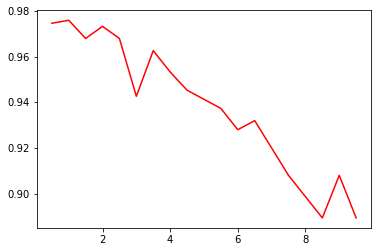

In [369]:
plt.plot(sigma_list,mean_acc,'r')
plt.show()

In [370]:
mean_acc[np.argmax(mean_acc)]*100

97.6

In [371]:
sigma_list[np.argmax(mean_acc)]

1.0

# Online mode

In [372]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [373]:
sigma = 5
T = len(train)
K = np.floor(100*T/sigma)

In [374]:
K

10000.0

In [456]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

In [457]:
tensor_train = TensorDataset(torch.tensor(X_train),torch.tensor(Y_train))
tensor_val = TensorDataset(torch.tensor(X_val),torch.tensor(Y_val))
tensor_test = TensorDataset(torch.tensor(X_test),torch.tensor(Y_test))

In [458]:
train_dataloader = DataLoader(tensor_train,batch_size = 1,shuffle=True)
val_dataloader = DataLoader(tensor_val,batch_size = len(X_val))
test_dataloader = DataLoader(tensor_test,batch_size = len(X_test))

In [459]:
for i,j in train_dataloader:
    print(i)
    print(j)
    break

tensor([-21.5571], dtype=torch.float64)
tensor([-1.], dtype=torch.float64)


In [460]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [461]:
net = LogisticRegression(1,1)

In [432]:
learning_rate = 1e-1
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr =  learning_rate, momentum = 0.9)

In [433]:
smoothed1 = gaussian_smoothed_density(x_train1,x=x_a)
smoothed2 = gaussian_smoothed_density(x_train2,x=x_b)

In [434]:
hint_space1 = np.random.choice(x_a,p=smoothed1/sum(smoothed1),size = 250)
hint_space2 = np.random.choice(x_b,p=smoothed2/sum(smoothed2),size = 250)

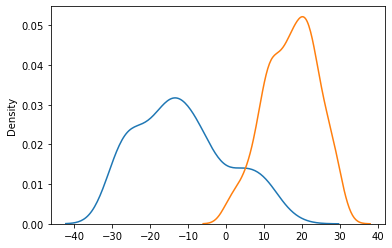

In [500]:
sns.kdeplot(hint_space1)
sns.kdeplot(hint_space2)
plt.show()

In [436]:
hint_space_x = np.hstack([hint_space1,hint_space2])

In [437]:
hint_space_y = np.hstack([-np.ones(250),np.ones(250)])

In [438]:
def training(model, trainloader, validloader):
#     train_loss_list = []
#     val_loss_list = []
    L = []
#    for epoch in range(epochs):
    train_loss = []
    val_loss = []
    s2t_x = []
    s2t_y = []
    l = 0
    i = 0
    model.train()
    for x,y in trainloader:
        i+=1
        print("Iteration {}".format(i))
        optimizer.zero_grad()

        hint_x = []
        hint_y = []
        for t in range(i,T+1):
            for k in range(np.int64(K/10)):
                random_idx = np.random.choice(range(len(hint_space_x)),size=1)
                hint_x.append(hint_space_x[random_idx][0])
                hint_y.append(hint_space_y[random_idx][0])

        s2t_x.append(x.detach().numpy()[0])
        s2t_y.append(y.detach().numpy()[0])

        train_set = []
        train_set.extend(hint_x*2)
        train_set.extend(s2t_x)
        #print(train_set)
        train_set = torch.tensor(np.array(train_set),requires_grad=True)

        label_set = []
        label_set.extend(hint_y*2)
        label_set.extend(s2t_y)
        label_set = torch.tensor(np.array(label_set),requires_grad=True)

        output = model(train_set.float().reshape(train_set.shape[0],1))
        loss = criterion(output.reshape(output.shape[0]), label_set.float())
        train_loss.append(loss.item())
        #print(len(output))
        prob = output[-1].detach().numpy()
        #print(prob[0])
        qt = 1 - 2*prob[0]
        p = [(1-qt)/2,1-((1-qt)/2)]
        yhat = np.random.choice(np.array([1.0,-1.0]), p = p, size=1)

        l += torch.square(torch.tensor(yhat[0],requires_grad=True) - y)

        loss.backward() 
        optimizer.step()
        #train_loss+=loss.item()
        L.append(l.item())
        #train_loss_list.append(train_loss/len(trainloader))
        print("Training loss ------- ", train_loss[-1])


    model.eval()
    for x_v, y_v in validloader:
        output_v = model(x_v.float().reshape(x_v.shape[0],1))
        #print(output_v)
        loss = criterion(output_v.reshape(output_v.shape[0]), y_v.float())            
        val_loss.append(loss.item())
    #val_loss_list.append(val_loss/len(validloader))
        print("validation loss ------- ", val_loss[-1])            

    return train_loss, val_loss, L  

In [439]:
tl, vl, L = training(net, train_dataloader, val_dataloader)

Iteration 1
Training loss -------  -3.448554515838623
Iteration 2
Training loss -------  -5.107099533081055
Iteration 3
Training loss -------  -4.139217853546143
Iteration 4
Training loss -------  -5.803321361541748
Iteration 5
Training loss -------  -8.755814552307129
Iteration 6
Training loss -------  -10.982768058776855
Iteration 7
Training loss -------  -12.468661308288574
Iteration 8
Training loss -------  -13.087770462036133
Iteration 9
Training loss -------  -14.462298393249512
Iteration 10
Training loss -------  -15.736287117004395
Iteration 11
Training loss -------  -15.66226863861084
Iteration 12
Training loss -------  -15.953871726989746
Iteration 13
Training loss -------  -16.683761596679688
Iteration 14
Training loss -------  -16.740516662597656
Iteration 15
Training loss -------  -16.858535766601562
Iteration 16
Training loss -------  -17.05835723876953
Iteration 17
Training loss -------  -17.402057647705078
Iteration 18
Training loss -------  -17.56296730041504
Iteration

Training loss -------  -18.78710174560547
Iteration 149
Training loss -------  -18.710145950317383
Iteration 150
Training loss -------  -18.626752853393555
Iteration 151
Training loss -------  -18.7279109954834
Iteration 152
Training loss -------  -19.075613021850586
Iteration 153
Training loss -------  -18.882768630981445
Iteration 154
Training loss -------  -18.676891326904297
Iteration 155
Training loss -------  -18.585311889648438
Iteration 156
Training loss -------  -18.614830017089844
Iteration 157
Training loss -------  -18.662199020385742
Iteration 158
Training loss -------  -18.45654296875
Iteration 159
Training loss -------  -18.547863006591797
Iteration 160
Training loss -------  -19.253694534301758
Iteration 161
Training loss -------  -18.952116012573242
Iteration 162
Training loss -------  -18.919204711914062
Iteration 163
Training loss -------  -18.871259689331055
Iteration 164
Training loss -------  -18.74492835998535
Iteration 165
Training loss -------  -18.476737976074

Training loss -------  -20.09988784790039
Iteration 294
Training loss -------  -20.158479690551758
Iteration 295
Training loss -------  -20.17252540588379
Iteration 296
Training loss -------  -20.240631103515625
Iteration 297
Training loss -------  -20.262685775756836
Iteration 298
Training loss -------  -20.16088104248047
Iteration 299
Training loss -------  -20.2728328704834
Iteration 300
Training loss -------  -20.387454986572266
Iteration 301
Training loss -------  -20.354949951171875
Iteration 302
Training loss -------  -20.4769287109375
Iteration 303
Training loss -------  -20.411043167114258
Iteration 304
Training loss -------  -20.44085693359375
Iteration 305
Training loss -------  -20.42415428161621
Iteration 306
Training loss -------  -20.55068588256836
Iteration 307
Training loss -------  -20.487918853759766
Iteration 308
Training loss -------  -20.506391525268555
Iteration 309
Training loss -------  -20.49680519104004
Iteration 310
Training loss -------  -20.509248733520508

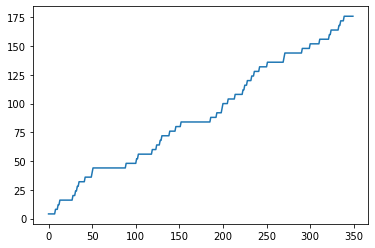

In [499]:
plt.plot(L)
plt.show()

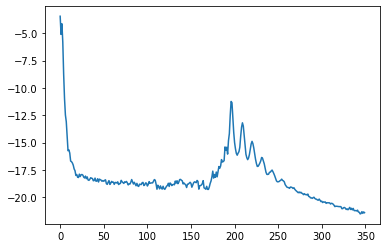

In [498]:
plt.plot(tl)
plt.show()

In [443]:
def test(model, testloader, threshold):
    correct = 0
    total = 0
    for x, y in testloader:
        output = model(x.float().reshape(x.shape[0],1))
        probs = [output[i].detach().numpy()[0] for i in range(len(output))]
        #print(probs)
        dec = []
        for i in range(len(probs)):
            if probs[i]>threshold:
                dec.append(1)
            else:
                dec.append(-1)
        labels = [y[i].detach().numpy().item() for i in range(len(y))]
    return np.sum(np.array(labels)==np.array(dec))/len(labels)

In [444]:
acc = test(net, test_dataloader,0.5)

In [445]:
acc

0.8533333333333334

# Training with Poisoned Data

In [462]:
train = np.hstack([samp,samp1])
y_train1 = np.zeros(len(x_train1))-1
y_train2 = np.ones(len(x_train2))
y_train = np.hstack([y_train1,y_train2])
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)
tensor_train = TensorDataset(torch.tensor(X_train),torch.tensor(Y_train))
tensor_val = TensorDataset(torch.tensor(X_val),torch.tensor(Y_val))
tensor_test = TensorDataset(torch.tensor(X_test),torch.tensor(Y_test))
train_dataloader = DataLoader(tensor_train,batch_size = 1,shuffle=True)
val_dataloader = DataLoader(tensor_val,batch_size = len(X_val))
test_dataloader = DataLoader(tensor_test,batch_size = len(X_test))

In [472]:
net = LogisticRegression(1,1)
learning_rate = 1e-1
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr =  learning_rate, momentum = 0.9)

In [473]:
poisoned_x1 = [samp[i]+np.random.normal(size=1) for i in range((len(samp)))]
poisoned_x2 = [samp[i]+np.random.normal(size=1) for i in range((len(samp)))]
poisoned_x = np.hstack([poisoned_x1,poisoned_x2])
hint_space_y = np.hstack([-np.ones(250),np.ones(250)])

In [474]:
def training(model, trainloader, validloader, epochs= T):
#     train_loss_list = []
#     val_loss_list = []
    L = []
#    for epoch in range(epochs):
    train_loss = []
    val_loss = []
    s2t_x = []
    s2t_y = []
    l = 0
    i = 0
    model.train()
    for x,y in trainloader:
        i+=1
        print(i)
        optimizer.zero_grad()

        hint_x = []
        hint_y = []
        for t in range(i,T+1):
            for k in range(np.int64(K/10)):
                random_idx = np.random.choice(range(len(poisoned_x)),size=1)
                hint_x.append(hint_space_x[random_idx][0])
                hint_y.append(hint_space_y[random_idx][0])

        s2t_x.append(x.detach().numpy()[0])
        s2t_y.append(y.detach().numpy()[0])

        train_set = []
        train_set.extend(hint_x*2)
        train_set.extend(s2t_x)
        #print(train_set)
        train_set = torch.tensor(np.array(train_set),requires_grad=True)

        label_set = []
        label_set.extend(hint_y*2)
        label_set.extend(s2t_y)
        label_set = torch.tensor(np.array(label_set),requires_grad=True)

        output = model(train_set.float().reshape(train_set.shape[0],1))
        loss = criterion(output.reshape(output.shape[0]), label_set.float())
        train_loss.append(loss.item())
        #print(len(output))
        prob = output[-1].detach().numpy()
        #print(prob[0])
        qt = 1 - 2*prob[0]
        p = [(1-qt)/2,1-((1-qt)/2)]
        yhat = np.random.choice(np.array([1.0,-1.0]), p = p, size=1)

        l += torch.square(torch.tensor(yhat[0],requires_grad=True) - y)

        loss.backward() 
        optimizer.step()
        #train_loss+=loss.item()
        L.append(l.item())
        #train_loss_list.append(train_loss/len(trainloader))
        print("Training loss ------- ", train_loss[-1])


    model.eval()
    for x_v, y_v in validloader:
        output_v = model(x_v.float().reshape(x_v.shape[0],1))
        #print(output_v)
        loss = criterion(output_v.reshape(output_v.shape[0]), y_v.float())            
        val_loss.append(loss.item())
    #val_loss_list.append(val_loss/len(validloader))
        print("validation loss ------- ", val_loss[-1])            

    return train_loss, val_loss, L  

In [475]:
tr, val, L1 = training(net, train_dataloader, val_dataloader)

1
Training loss -------  40.25875473022461
2
Training loss -------  -8.00290584564209
3
Training loss -------  -17.206119537353516
4
Training loss -------  -27.581851959228516
5
Training loss -------  -32.632469177246094
6
Training loss -------  -35.535762786865234
7
Training loss -------  -35.20000457763672
8
Training loss -------  -36.43624496459961
9
Training loss -------  -35.17352294921875
10
Training loss -------  -35.917606353759766
11
Training loss -------  -35.86801528930664
12
Training loss -------  -36.91200256347656
13
Training loss -------  -36.95030975341797
14
Training loss -------  -37.30353927612305
15
Training loss -------  -37.5386848449707
16
Training loss -------  -37.38566207885742
17
Training loss -------  -37.92243194580078
18
Training loss -------  -37.871578216552734
19
Training loss -------  -37.856361389160156
20
Training loss -------  -37.86943435668945
21
Training loss -------  -37.98716735839844
22
Training loss -------  -38.17805480957031
23
Training los

Training loss -------  -38.11114501953125
182
Training loss -------  -37.93800354003906
183
Training loss -------  -38.03903579711914
184
Training loss -------  -38.037384033203125
185
Training loss -------  -37.8980598449707
186
Training loss -------  -38.10395050048828
187
Training loss -------  -38.09303665161133
188
Training loss -------  -38.62806701660156
189
Training loss -------  -38.241207122802734
190
Training loss -------  -38.19361877441406
191
Training loss -------  -37.86408615112305
192
Training loss -------  -38.39420700073242
193
Training loss -------  -38.22473907470703
194
Training loss -------  -38.12291717529297
195
Training loss -------  -38.21418762207031
196
Training loss -------  -38.41267013549805
197
Training loss -------  -38.234214782714844
198
Training loss -------  -37.93624496459961
199
Training loss -------  -38.212867736816406
200
Training loss -------  -37.79317855834961
201
Training loss -------  -38.34834671020508
202
Training loss -------  -38.5585

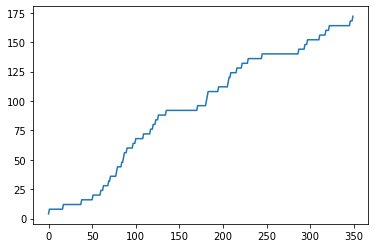

In [496]:
plt.plot(L1)
plt.show()

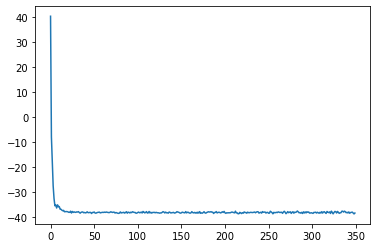

In [497]:
plt.plot(tr)
plt.show()

In [478]:
def test(model, testloader, threshold):
    correct = 0
    total = 0
    for x, y in testloader:
        output = model(x.float().reshape(x.shape[0],1))
        probs = [output[i].detach().numpy()[0] for i in range(len(output))]
        #print(probs)
        dec = []
        for i in range(len(probs)):
            if probs[i]>threshold:
                dec.append(1)
            else:
                dec.append(-1)
        labels = [y[i].detach().numpy().item() for i in range(len(y))]
    return np.sum(np.array(labels)==np.array(dec))/len(labels)

In [479]:
acc_poisoned = test(net, test_dataloader,0.5)

In [480]:
acc_poisoned

0.92

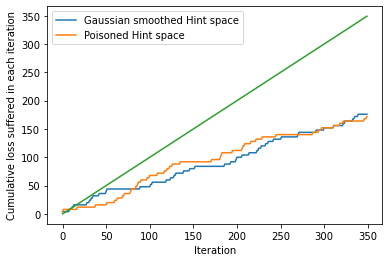

In [494]:
L2 = [i  for i in range(len(L1))]
plt.plot(L)
plt.plot(L1)
plt.plot(L2)
plt.xlabel("Iteration")
plt.ylabel("Cumulative loss suffered in each iteration")
plt.legend(["Gaussian smoothed Hint space","Poisoned Hint space"])
plt.show()

In [ ]:
def training(model, trainloader, validloader, epochs= T):
    train_loss_list = []
    val_loss_list = []
    L = []
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        s2t_x = []
        s2t_y = []
        l = 0
        model.train()
        for x,y in trainloader:
            optimizer.zero_grad()
            
            hint_x = []
            hint_y = []
            for t in range(epoch+1,T+1):
                for k in range(np.int64(K/10)):
                    random_idx = np.random.choice(range(len(hint_space_x)),size=1)
                    hint_x.append(hint_space_x[random_idx][0])
                    hint_y.append(hint_space_y[random_idx][0])
            
            s2t_x.append(x.detach().numpy()[0])
            s2t_y.append(y.detach().numpy()[0])
            
            train_set = []
            train_set.extend(hint_x*2)
            train_set.extend(s2t_x)
            #print(train_set)
            train_set = torch.tensor(np.array(train_set),requires_grad=True)
            
            label_set = []
            label_set.extend(hint_y*2)
            label_set.extend(s2t_y)
            label_set = torch.tensor(np.array(label_set),requires_grad=True)
            
            output = model(train_set.float().reshape(train_set.shape[0],1))
            loss = criterion(output.reshape(output.shape[0]), label_set.float()) 
            #print(len(output))
            prob = output[-1].detach().numpy()
            #print(prob[0])
            qt = 1 - 2*prob[0]
            p = [(1-qt)/2,1-((1-qt)/2)]
            yhat = np.random.choice(np.array([1.0,-1.0]), p = p, size=1)
            
            l += torch.square(torch.tensor(yhat[0],requires_grad=True) - y)
            
            loss.backward() 
            optimizer.step()
            train_loss+=loss.item()
        L.append(l.item())
        train_loss_list.append(train_loss/len(trainloader))
        print("Training loss ------- ", train_loss_list[-1])
        
        
        model.eval()
        for x_v, y_v in validloader:
            output_v = model(x_v.float().reshape(x_v.shape[0],1))
            #print(output_v)
            loss = criterion(output_v.reshape(output_v.shape[0]), y_v.float())            
            val_loss+=loss.item()
        val_loss_list.append(val_loss/len(validloader))
        print("validation loss ------- ", val_loss_list[-1])            
        
    return train_loss_list, val_loss_list, L  